In [5]:
import os
import re
import sys
import math
import glob as gb
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

sys.dont_write_bytecode = True

src_path = os.getcwd()
rng = np.random.default_rng(0)   # seed reproducible


from utils.plotting_raw_data import plot_outputs_vs_progvar
from utils.plotting_JPDF import plot_JPDF

### Importing Data

In [6]:
# Read the data from the FlameMaster files
fname = 'data/chemtable_FVV_2D_Enthalpy/*.kg'
files = gb.glob(fname)
nfiles = len(files)


# Read column names from the second line of the first file
with open(files[0], 'r') as f:
    lines = f.readlines()
    column_names = lines[1].strip().split('\t')  # Read second line (index 1) and split by whitespace


# Create empty lists to store the data
data_flameMaster = []

# Load and concatenate the data into DataFrames
for f in files:

    df_flameMaster_temp = pd.DataFrame(np.loadtxt(f, skiprows=2, dtype=np.float64),columns=column_names)
    data_flameMaster.append(df_flameMaster_temp)

# Concatenate all data into final DataFrames
df_flameMaster_all = pd.concat(data_flameMaster, ignore_index=True)

#Computing diffusivity 
df_flameMaster_all['Diff [kg/ms]'] = df_flameMaster_all['lambda [W/mK]'] / df_flameMaster_all['cp [J/kgK]']

# Select the relevant columns for input and output
input_data = ['ProgVar', 'TotalEnthalpy [J/kg]']
referenceEnthalpy = 276240

# Shift the enthalpy values to be relative to the reference enthalpy
df_flameMaster_all['TotalEnthalpy [J/kg]'] = df_flameMaster_all['TotalEnthalpy [J/kg]'] - referenceEnthalpy

# Select the relevant columns for input and output
output_data = ['ProdRateProgVar [kg/m^3s]', 'temperature [K]', 'Y-CO', 'density', 'mu [kg/ms]', 'cp [J/kgK]', 'Diff [kg/ms]']

# Create DataFrames for input and output data
X_all = df_flameMaster_all[input_data].to_numpy()
Z_all = df_flameMaster_all[output_data].to_numpy()

# # Split the data into training and testing sets
mask = np.random.choice([True, False], len(X_all), p=[0.80, 0.2])

# # Save mask dfor UQ analysis
# np.save("train_test_mask.npy", mask)
X_train = X_all[mask]
Z_train = Z_all[mask]            
    
X_test = X_all[~mask]    
Z_test = Z_all[~mask]   


In [7]:
import numpy as np
import os

def make_splits_and_subsets(N_total, test_frac, train_sizes, seeds, out_dir, base_seed=123):
    """
    Creates:
      - test_idx.npy
      - train_pool_idx.npy
      - train_subsets_seed{seed}.npz  (contains train_{N} arrays)

    Parameters
    ----------
    N_total : int
        Total number of samples in the full dataset (e.g., 80000)
    test_frac : float
        Fraction for test set (e.g., 0.2)
    train_sizes : list[int]
        Training sizes to benchmark (e.g., [10000,20000,...,64000])
    seeds : list[int]
        Seeds for repeated experiments (e.g., [0,1,2,3,4])
    out_dir : str
        Folder to store splits
    base_seed : int
        Seed for the fixed train/test split (keep constant forever)
    """
    os.makedirs(out_dir, exist_ok=True)

    rng = np.random.default_rng(base_seed)
    all_idx = np.arange(N_total)

    # Fixed test split
    rng.shuffle(all_idx)
    n_test = int(test_frac * N_total)
    test_idx = all_idx[:n_test]
    train_pool_idx = all_idx[n_test:]

    np.save(os.path.join(out_dir, "test_idx.npy"), test_idx)
    np.save(os.path.join(out_dir, "train_pool_idx.npy"), train_pool_idx)

    # Create nested train subsets per seed
    for s in seeds:
        rng_s = np.random.default_rng(s)
        perm = rng_s.permutation(train_pool_idx)

        data = {}
        for N in train_sizes:
            if N > len(train_pool_idx):
                raise ValueError(f"N={N} exceeds train pool size {len(train_pool_idx)}")
            data[f"train_{N}"] = perm[:N]

        np.savez(os.path.join(out_dir, f"train_subsets_seed{s}.npz"), **data)

    print("Saved splits to:", out_dir)


# Example for your case
N_total = 80000
test_frac = 0.2
n_test = int(test_frac * N_total)
n_train_pool = N_total - n_test  # this will be 64995

train_sizes = [4000, 8000, 12000, 16000, 20000, 24000, 32000]
seeds = [0, 1, 2, 3, 4]
out_dir = "./splits_uq"

make_splits_and_subsets(N_total, test_frac, train_sizes, seeds, out_dir)


Saved splits to: ./splits_uq


### Plotting raw data

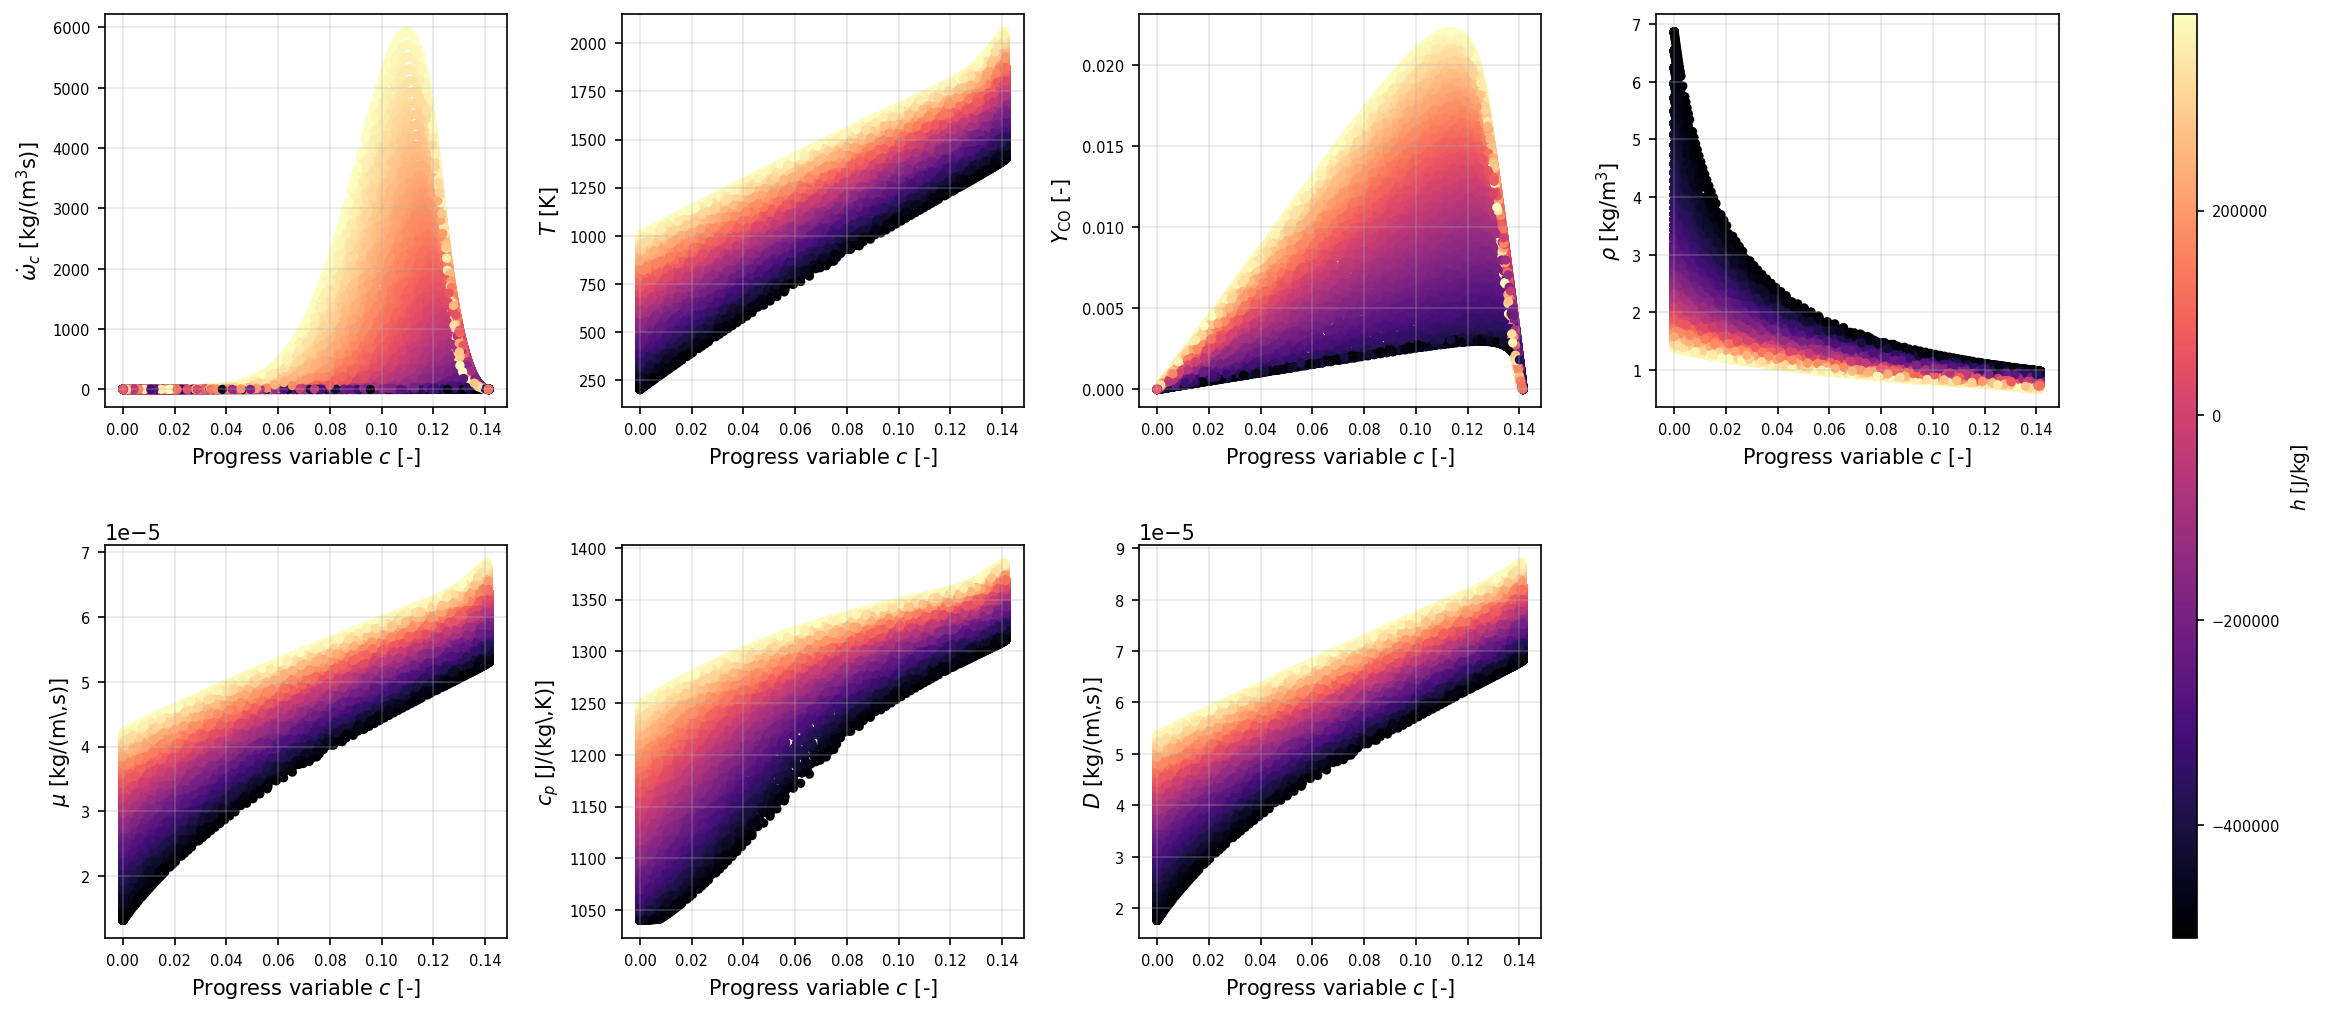

In [6]:
plot_outputs_vs_progvar(
    df=df_flameMaster_all,
    output_cols=output_data,
    mask=mask,
    n_points=64000,
    save_name="figs/Outputs_vs_ProgVar"
)


### Preprocessing data for training, validation and testing

In [10]:
import torch
import onnx
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def signed_log1p(y):
    return np.sign(y) * np.log1p(np.abs(y))

def signed_expm1(y):
    return np.sign(y) * np.expm1(np.abs(y))

# Select a reduced number of data
n_samples = 80000
idx = rng.choice(df_flameMaster_all.index, size=n_samples, replace=False)
df_flameMaster_all = df_flameMaster_all.loc[idx]

# 1) arrays
X = df_flameMaster_all[input_data].to_numpy(dtype=np.float32)
Y = signed_log1p(df_flameMaster_all[output_data].to_numpy(dtype=np.float32))

# 2) split
X_train, X_tmp, Y_train, Y_tmp = train_test_split(X, Y, test_size=0.2, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_tmp, Y_tmp, test_size=0.5, random_state=0)

# 3) Computing scalers 
x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(Y_train)

# 4) Applying scalers 
X_train_s = x_scaler.transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

Y_train_s = y_scaler.transform(Y_train)
Y_val_s   = y_scaler.transform(Y_val)
Y_test_s  = y_scaler.transform(Y_test)

# 4) Converting to torch tensors
X_train_t = torch.from_numpy(X_train_s).float()
X_val_t   = torch.from_numpy(X_val_s).float()
X_test_t  = torch.from_numpy(X_test_s).float()

Y_train_t = torch.from_numpy(Y_train_s).float()
Y_val_t   = torch.from_numpy(Y_val_s).float()
Y_test_t  = torch.from_numpy(Y_test_s).float()

print(X_train_t.shape, Y_train_t.shape)

torch.Size([64000, 2]) torch.Size([64000, 7])


In [11]:
Yco_true = df_flameMaster_all["Y-CO"].to_numpy(dtype=np.float64)
print("Y-CO true min:", Yco_true.min(), "max:", Yco_true.max())


Y-CO true min: 1.03648e-12 max: 0.022055


In [12]:
class MLP(nn.Module):
    def __init__(self, n_inputs = 2, n_outputs = 7):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.SiLU(),
            nn.Linear(64,  64),
            nn.SiLU(),
            nn.Linear(64, 64),
            nn.SiLU(),
            nn.Linear(64, n_outputs)
        )

    def forward(self, x):
        return self.net(x)


### Instanciate the model

In [13]:
model = MLP(n_inputs=2, n_outputs=7)

### Data loader

In [14]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 4000

train_ds = TensorDataset(X_train_t,Y_train_t)
val_ds = TensorDataset(X_val_t, Y_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)



### Loss +  Optimizer

In [15]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=10
)



### Train + Validation Loop

In [16]:
def run_epoch(model, loader, loss_fn, optimizer = None):
    is_train = optimizer is not None

    model.train() if is_train else model.eval()

    total_loss = 0.0
    n_samples = 0
   
    context = torch.enable_grad() if is_train else torch.no_grad()
    with context:
        for xb, yb in loader:
            if is_train: optimizer.zero_grad()

            pred = model(xb)
            loss = loss_fn(pred,yb)

            if is_train:
                loss.backward()
                optimizer.step()

            bs = xb.size(0)
            total_loss += loss.item() * bs
            n_samples += bs

    return total_loss / n_samples

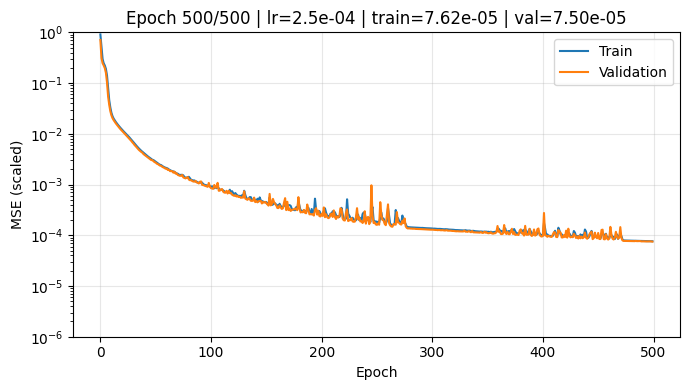

Epoch 500 | train MSE: 7.6237e-05 | val MSE: 7.4985e-05


In [17]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

epochs = 500
plot_every = 5 

train_losses, val_losses = [], []

for epoch in range(1, epochs + 1):
    train_loss = run_epoch(model, train_loader, loss_fn, optimizer=optimizer)
    val_loss   = run_epoch(model, val_loader,   loss_fn, optimizer=None)

    scheduler.step(val_loss)


    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % plot_every == 0 or epoch == 1:
        current_lr = optimizer.param_groups[0]["lr"]
        clear_output(wait=True)
        plt.figure(figsize=(7,4))
        plt.plot(train_losses, label="Train")
        plt.plot(val_losses, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("MSE (scaled)")
        plt.yscale("log") 
        plt.ylim(1e-6, 1e0)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.title(f"Epoch {epoch}/{epochs} | lr={current_lr:.1e} | train={train_loss:.2e} | val={val_loss:.2e}")
        plt.tight_layout()
        plt.show()

    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:3d} | train MSE: {train_loss:.4e} | val MSE: {val_loss:.4e}")


### Uncertainty quantification wrapper

In [18]:
import torch
import torch.nn as nn

class UQWrapper(nn.Module):
    def __init__(self, core_model: nn.Module, x_mean, x_std, y_mean, y_std, clamp_exp=50.0):
        super().__init__()
        self.core = core_model
        self.register_buffer("x_mean", x_mean)  # shape [2]
        self.register_buffer("x_std",  x_std)   # shape [2]
        self.register_buffer("y_mean", y_mean)  # shape [7]
        self.register_buffer("y_std",  y_std)   # shape [7]
        self.clamp_exp = float(clamp_exp)

    def forward(self, x_raw: torch.Tensor) -> torch.Tensor:
        # x_raw: [N,2] raw (C,h)
        x_scaled = (x_raw - self.x_mean) / self.x_std
        y_scaled = self.core(x_scaled)                 # [N,7]
        y_log = y_scaled * self.y_std + self.y_mean    # [N,7]

        a = torch.clamp(torch.abs(y_log), max=self.clamp_exp)
        y_lin = torch.sign(y_log) * (torch.exp(a) - 1.0)

        # Enforce physical constraint for Y-CO (index 2): Y-CO >= 0
        y_lin[:, 2] = torch.clamp(y_lin[:, 2], min=0.0)
        return y_lin
    

model.eval()

x_mean = torch.tensor(x_scaler.mean_,  dtype=torch.float32)   # (2,)
x_std  = torch.tensor(x_scaler.scale_, dtype=torch.float32)   # (2,)

y_mean = torch.tensor(y_scaler.mean_,  dtype=torch.float32)   # (7,)
y_std  = torch.tensor(y_scaler.scale_, dtype=torch.float32)   # (7,)

model_uq = UQWrapper(model, x_mean, x_std, y_mean, y_std).eval()

dummy = torch.zeros(1, 2, dtype=torch.float32)  # [N,2]

torch.onnx.export(
    model_uq,
    dummy,
    "./saved_models/NN_model_for_uq_analysis.onnx",
    input_names=["inputs"],
    output_names=["outputs"],
    dynamic_axes={"inputs": {0: "N"}, "outputs": {0: "N"}},
    opset_version=17
)




/tmp/zp252136/login23-1_274127/ipykernel_83589/3939362932.py:40: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


###  This is only to make compatible wit CIAO

In [19]:
# class WrapperONNX(nn.Module):
#     def __init__(self, core_model: nn.Module, x_mean, x_std, y_mean, y_std,
#                  clamp_exp: float = 50.0):
#         super().__init__()
#         self.core = core_model
#         self.register_buffer("x_mean", x_mean)
#         self.register_buffer("x_std",  x_std)
#         self.register_buffer("y_mean", y_mean)
#         self.register_buffer("y_std",  y_std)
#         self.clamp_exp = float(clamp_exp)

#     def forward(self, x_raw: torch.Tensor) -> torch.Tensor:
#         # x_raw: [B,nx,ny,nz,2] or [B,nx,ny,2] or [N,2]
#         orig_shape = x_raw.shape

#         # Flatten to [N,2] if needed
#         if x_raw.dim() >= 3:
#             x2 = x_raw.reshape(-1, orig_shape[-1])   # [-1, 2]
#         else:
#             x2 = x_raw                                # already [N,2]

#         # Normalize inputs (expect x_mean/x_std broadcastable to [N,2])
#         x_scaled = (x2 - self.x_mean) / self.x_std

#         # Core NN predicts scaled outputs: [N,7]
#         y_scaled = self.core(x_scaled)

#         # Denormalize to y_log (signed-log space): [N,7]
#         y_log = y_scaled * self.y_std + self.y_mean

#         # signed_expm1: sign(z) * (exp(|z|) - 1)
#         a = torch.abs(y_log)
#         a = torch.clamp(a, max=self.clamp_exp)
#         y_lin = torch.sign(y_log) * (torch.exp(a) - 1.0)

#         # Enforce physical constraint for Y-CO (index 2): Y-CO >= 0
#         y_lin[:, 2] = torch.clamp(y_lin[:, 2], min=0.0)

#         # Reshape back to field if original was field-shaped
#         if len(orig_shape) == 5:
#             B, nx, ny, nz, _ = orig_shape
#             y_out = y_lin.reshape(B, nx, ny, nz, y_lin.shape[-1])  # [B,nx,ny,nz,7]
#         elif len(orig_shape) == 4:
#             B, nx, ny, _ = orig_shape
#             y_out = y_lin.reshape(B, nx, ny, y_lin.shape[-1])      # [B,nx,ny,7]
#         else:
#             y_out = y_lin  # [N,7]

#         return y_out

In [20]:
# model.eval()

# x_mean = torch.tensor(x_scaler.mean_,  dtype=torch.float32)   # (2,)
# x_std  = torch.tensor(x_scaler.scale_, dtype=torch.float32)   # (2,)

# y_mean = torch.tensor(y_scaler.mean_,  dtype=torch.float32)   # (7,)
# y_std  = torch.tensor(y_scaler.scale_, dtype=torch.float32)   # (7,)

# wrapped_model = WrapperONNX(model, x_mean, x_std, y_mean, y_std)
# wrapped_model.eval()

In [21]:
# dummy_input = torch.randn(1, 10, 8, 1, 2, dtype=torch.float32)

# onnx_path = "./saved_models/NN_combust_model_CIAO.onnx"

# torch.onnx.export(
#     wrapped_model,  
#     dummy_input,
#     onnx_path,
#     export_params=True,
#     opset_version=17,
#     input_names=["input"],
#     output_names=["outputs"],
#     dynamic_axes={
#         "input":   {0:"B", 1:"nx", 2:"ny", 3:"nz"},
#         "outputs": {0:"B", 1:"nx", 2:"ny", 3:"nz"},
#     },
# )

# field_names = ["SRC_PROG", "T", "Y_CO", "RHO", "VISC", "CP", "DIFF"]

# m = onnx.load("./saved_models/NN_combust_model_CIAO.onnx")

# p = m.metadata_props.add()
# p.key = "output_fields"
# p.value = ",".join(field_names)

# onnx.save(m, onnx_path)  # overwrite, or save to a new file
# print("Saved ONNX with metadata:", onnx_path)


### Checking accuracy

Test MSE (scaled): 7.3328e-05
ProdRateProgVar [kg/m^3s]      rRMSE = 2.8109 %
temperature [K]                rRMSE = 0.2368 %
Y-CO                           rRMSE = 1.3316 %
density                        rRMSE = 0.4548 %
mu [kg/ms]                     rRMSE = 0.2161 %
cp [J/kgK]                     rRMSE = 0.3444 %
Diff [kg/ms]                   rRMSE = 0.2484 %
R2: 0.9992, NMSE: 0.0007349536172114313


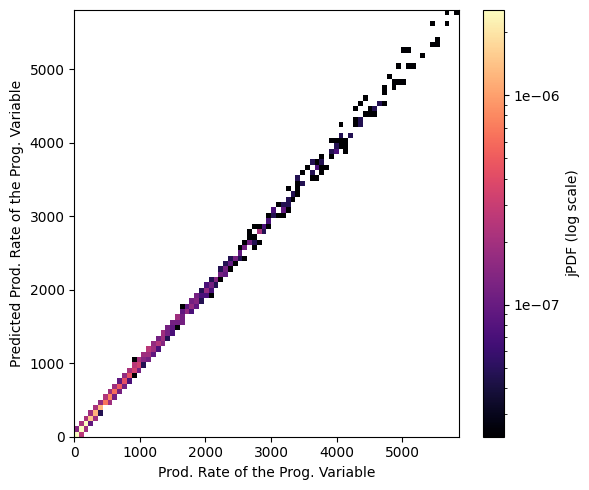

In [22]:
# --- Test evaluation: MSE (scaled) + NMSE (physical space) ---

model.eval()

with torch.no_grad():
    Y_pred_scaled = model(X_test_t)
    test_loss = loss_fn(Y_pred_scaled, Y_test_t)

print(f"Test MSE (scaled): {test_loss.item():.4e}")

# Back to physical space (inverse scaler + inverse signed log1p)
Y_pred = signed_expm1(y_scaler.inverse_transform(Y_pred_scaled.cpu().numpy()))
Y_true = signed_expm1(y_scaler.inverse_transform(Y_test_t.cpu().numpy()))

# NMSE per output: mean((e^2)) / mean((y_true^2))
eps = 1e-12
rRMSE = np.sqrt(np.mean((Y_pred - Y_true) ** 2, axis=0)) / (Y_true.std(axis=0) + eps)

for name, e in zip(output_data, rRMSE):
    print(f"{name:30s} rRMSE = {e* 100:.4f} %")


plot_JPDF(
    df_true=Y_true[:, 0],
    df_pred=Y_pred[:, 0],
    bins=80,
    x_label="Prod. Rate of the Prog. Variable",
    y_label="Predicted Prod. Rate of the Prog. Variable",
)





In [23]:
Yco_pred = Y_pred[:, 2]  # assuming index 2 is Y-CO
neg_mask = Yco_pred < 0

print("Negative fraction:", neg_mask.mean())
print("Most negative value:", Yco_pred.min())
print("20% quantile:", np.quantile(Yco_pred, 0.2))


Negative fraction: 0.3625
Most negative value: -2.1708578e-05
20% quantile: -2.1936441e-06
